In [1]:
import numpy as np

from neurodsp.sim import sim_oscillation, sim_synaptic_kernel
from timescales.sim import sim_spikes_prob

from timescales.conversions import convert_knee
from timescales.pipe import Pipe

import matplotlib.pyplot as plt
from timescales.plts import plot_connected_scatter, set_default_rc

set_default_rc()

# Figure 4. Bias Solutions

Simulation and analysis pipelines are created below to evaluate bias from finite duration and oscillations. For finite bias, autoregressive PSD recovers ground truth more accurately than Welch's PSD. Oscillatory bias is best account for using peaks in spectral parameterization.

#### Oscillatory Solution

In [2]:
# Settings
n_seconds = 100
fs = 1000
tau =  convert_knee(10)
kernel = sim_synaptic_kernel(10 * tau, fs, 0, tau)
seeds = np.arange(200)

# Create and run a pipeline for oscillatory bias
pipe_osc = Pipe(n_seconds, fs, seeds)

pipe_osc.add_step('simulate', sim_spikes_prob, kernel, mu=250, rescale=(0, .8))
pipe_osc.add_step('simulate', sim_oscillation, 20, rescale=(0, .2))
pipe_osc.add_step('sample', fs=5000)
pipe_osc.add_step('bin', 10)

pipe_osc.add_step('transform', 'PSD')

pipe_osc.add_step('fit', ['tau', 'rsq', ],
                  f_range=(1, 100), fooof_init={'max_n_peaks': 0})
pipe_osc.add_step('fit', ['tau', 'rsq'],
                  f_range=(1, 100), fooof_init={'max_n_peaks': 1})

pipe_osc.run(progress='tqdm.notebook')

Fitting Timescales:   0%|          | 0/200 [00:00<?, ?it/s]

#### Finite Solution

In [77]:
# Settings
n_seconds = 2
fs = 2000
seeds = np.arange(200)

tau =  convert_knee(10)
kernel = sim_synaptic_kernel(10 * tau, fs, 0, tau)

bounds = [[-np.inf, 3,       0,      0],
          [ np.inf, 100,  np.inf, np.inf]]

guess = [0, 10, 1, 1e-6]


# Create and run a pipeline for finite bias
pipe_finite = Pipe(n_seconds, fs, seeds)

pipe_finite.add_step('simulate', sim_spikes_prob, kernel, mu=250, rescale=(0, 1))
pipe_finite.add_step('sample', fs=10000)
pipe_finite.add_step('bin', 5)

pipe_finite.add_step('transform', 'PSD')
pipe_finite.add_step('transform', 'PSD', ar_order=20)

pipe_finite.add_step('fit', ['tau', 'rsq'], f_range=(1, 100), bounds=bounds, guess=guess)

pipe_finite.run(progress='tqdm.notebook')

Fitting Timescales:   0%|          | 0/200 [00:00<?, ?it/s]

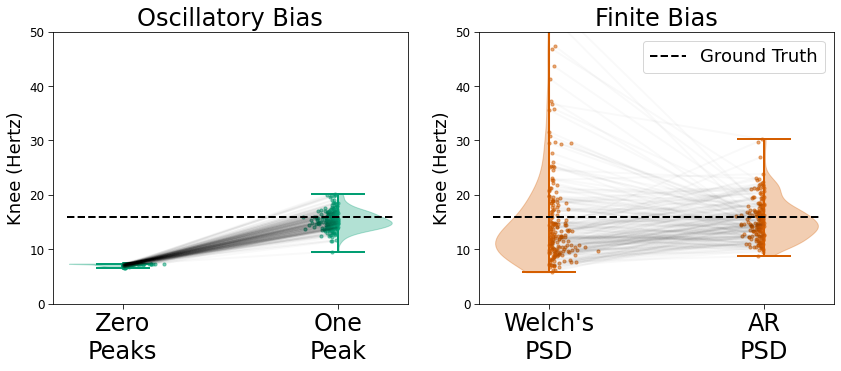

In [78]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

plot_connected_scatter(pipe_osc.results[:500, 0, 0]*1000, pipe_osc.results[:500, 1, 0]*1000,
                       axes[0], line_color='k', line_alpha=.025, scatter_jit=.1,
                       colors=['C2', 'C2'], xticklabels=['Zero\nPeaks', 'One\nPeak'])

plot_connected_scatter(pipe_finite.results[:500, 0, 0]*1000, pipe_finite.results[:500, 1, 0]*1000,
                       axes[1], line_color='k', line_alpha=.025, scatter_jit=.1,
                       colors=['C3', 'C3'], xticklabels=['Welch\'s\nPSD', 'AR\nPSD'])

axes[0].axhline(convert_knee(10)*1000, .04, .96, color='k', ls='--')
axes[1].axhline(convert_knee(10)*1000, .04, .96, color='k', label='Ground Truth', ls='--')

axes[0].set_ylim(0, 50)
axes[1].set_ylim(0, 50)

axes[0].set_title('Oscillatory Bias')
axes[1].set_title('Finite Bias')

axes[0].set_ylabel('Knee (Hertz)')
axes[1].set_ylabel('Knee (Hertz)')

axes[1].legend()

#plt.savefig('fig04_bias_solutions.png', dpi=300, facecolor='white');

In [44]:
(1/(2*np.pi*10)) * 1000

15.915494309189533

In [45]:
convert_knee(10)*1000

15.915494309189533